<a href="https://colab.research.google.com/github/simran-dk/Practice_Projects/blob/main/Gett_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df_offers = pd.read_csv('/content/data_offers.csv')
df_orders = pd.read_csv('/content/data_orders.csv')

In [32]:
combined_df = pd.merge(df_orders, df_offers, on='order_gk')
combined_df['hour'] = pd.to_datetime(combined_df['order_datetime']).dt.hour
combined_df.head()

/tmp/ipython-input-408248924.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['hour'] = pd.to_datetime(combined_df['order_datetime']).dt.hour


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174,20
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180,20
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275,12


##Task 1: Build up distribution of orders according to reasons for failure

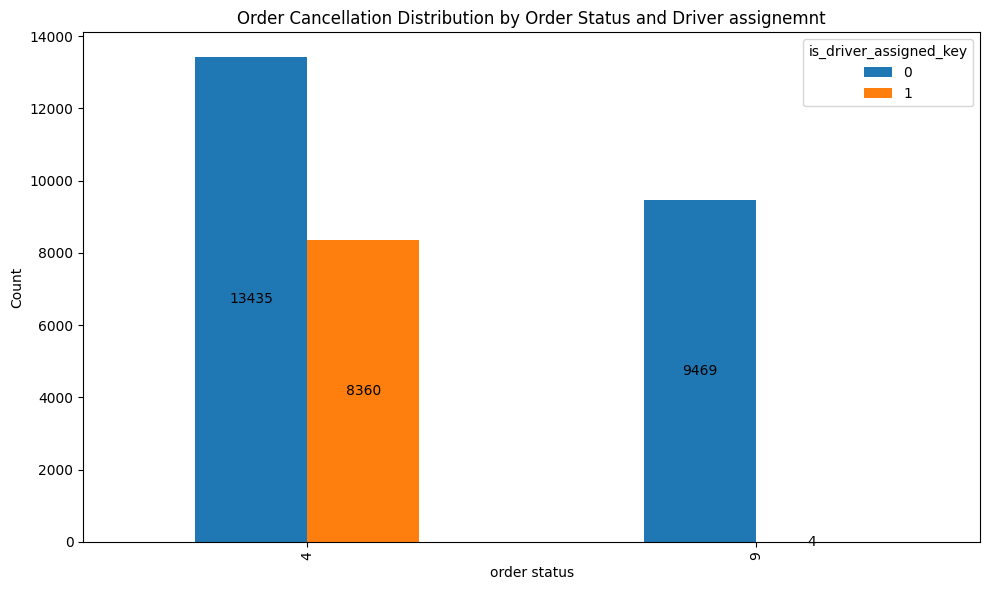

In [37]:
explore_df = combined_df.groupby(['is_driver_assigned_key', 'order_status_key']).size().reset_index(name='count')
explore_df
pivot_df = explore_df.pivot(index='order_status_key', columns = 'is_driver_assigned_key', values = 'count').fillna(0)

ax = pivot_df.plot(kind='bar',  figsize=(10,6))
plt.xlabel('order status')
plt.ylabel('Count')
plt.title('Order Cancellation Distribution by Order Status and Driver assignemnt')

for container in ax.containers:
  ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()

##Task 2: Plot the distribution of failed orders by hours

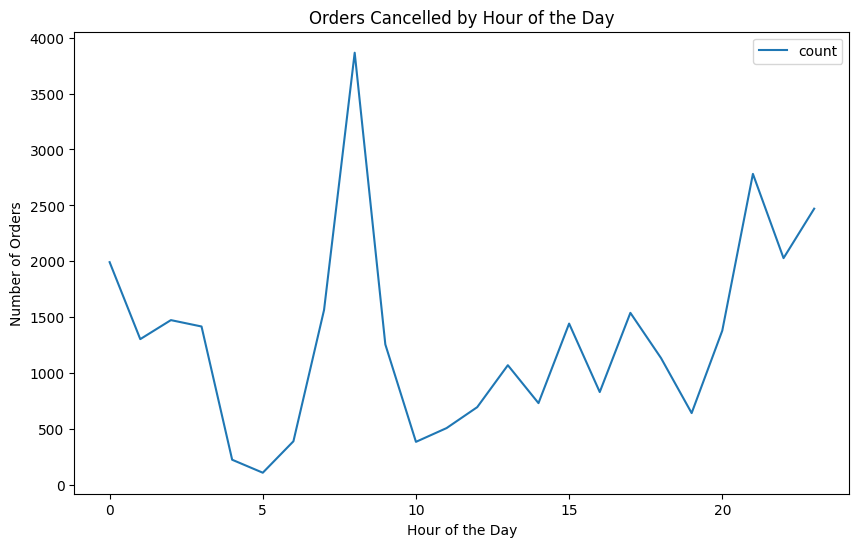

In [39]:
t2_df = combined_df.groupby('hour').size().reset_index(name='count')

t2_df.plot(kind='line', x='hour', y='count', figsize=(10,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.title('Orders Cancelled by Hour of the Day')
plt.show()

##Task 3: Plot the average time to cancellation with and without driver, by the hour

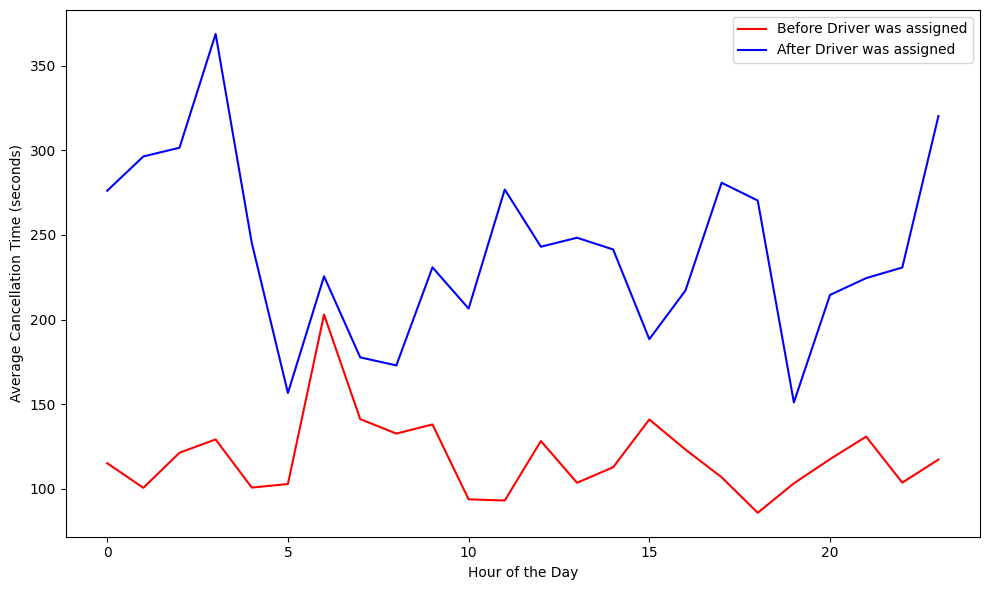

In [40]:
t3_df = combined_df.groupby(['is_driver_assigned_key', 'hour'])['cancellations_time_in_seconds'].mean().reset_index()

t3_pivot = t3_df.pivot(index='hour', columns='is_driver_assigned_key', values='cancellations_time_in_seconds').fillna(0)

t3_pivot.plot(kind='line', figsize=(10,6), color=('red','blue'))
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (seconds)')
plt.legend(['Before Driver was assigned', 'After Driver was assigned'])
plt.tight_layout()
plt.show()

##Task 4: Plot the distribution of average ETA by hours

/tmp/ipython-input-1630419059.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


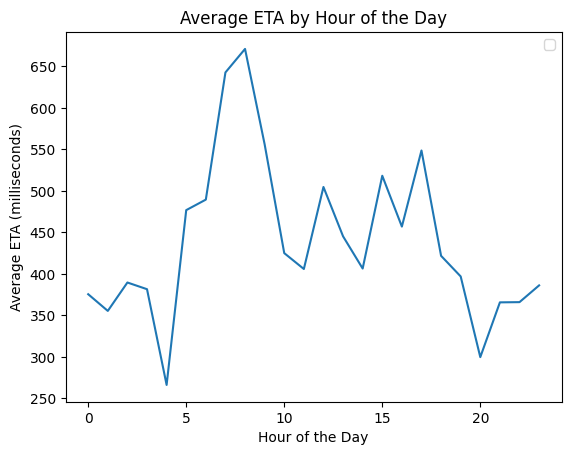

In [41]:
t4_df = combined_df.groupby('hour')['m_order_eta'].mean().reset_index()
plt.plot(t4_df['hour'], t4_df['m_order_eta'])
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (milliseconds)')
plt.title('Average ETA by Hour of the Day')
plt.legend()
plt.show()

##Task 5: BONUS Hexagons. How many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [66]:
%pip install h3

In [67]:
%pip install geopandas

In [48]:
import h3
t5_df = combined_df.copy()
t5_df['hex_id'] = t5_df.apply(lambda row: h3.latlng_to_cell(row['origin_latitude'],row['origin_longitude'],8), axis=1)

top_df = t5_df.groupby('hex_id').size().reset_index(name='order_counts')
top_df.sort_values(by='order_counts', ascending=False, inplace=True)
top_df['cumulative_sum'] = top_df['order_counts'].cumsum()
top_df['percentage_of_total'] = top_df['cumulative_sum']/(top_df['order_counts'].sum())
result80 = top80_df[top80_df['percentage_of_total'] <= 0.8]
print(result80)
print(f"\n{len(result80)} size 8 hexes contain 80% of all orders")

              hex_id  order_counts  cumulative_sum  percentage_of_total
93   88195d2b1dfffff          4488            4488             0.143533
92   88195d2b1bfffff          2603            7091             0.226781
89   88195d2b15fffff          2461            9552             0.305488
87   88195d2b11fffff          2191           11743             0.375560
91   88195d2b19fffff          1960           13703             0.438244
20   88195d284dfffff          1937           15640             0.500192
61   88195d2a27fffff          1295           16935             0.541608
85   88195d2b0bfffff          1091           18026             0.576500
60   88195d2a25fffff          1074           19100             0.610848
88   88195d2b13fffff           975           20075             0.642030
82   88195d2b03fffff           751           20826             0.666048
90   88195d2b17fffff           588           21414             0.684854
104  88195d2b39fffff           559           21973             0

In [68]:
%pip install folium

In [65]:
from matplotlib import colors
import folium
import branca.colormap as cm

m = folium.Map(location=[combined_df['origin_latitude'].mean(), combined_df['origin_longitude'].mean()], zoom_start= 10)

color_map = cm.LinearColormap(
    colors=['green', 'yellow', 'orange', 'red'],
    vmin = top_df['percentage_of_total'].min(),
    vmax = top_df['percentage_of_total'].max()
)

for _, row in top_df.iterrows():
    hex_boundary = h3.cell_to_boundary(row['hex_id'])
    folium.Polygon(
        locations=hex_boundary,
        color='blue',
        fill=True,
        fill_color= color_map(row['percentage_of_total']),
        fill_opacity=0.7,
    ).add_to(m)

m